<div align="center">

# Machine Learning Model Development and Optimization Report

</div>


## Executive Summary

> This report details the development and optimization of machine learning models for a multimodal prediction task involving tabular, text, and image data. Through systematic experimentation, significant improvements in prediction accuracy was achieved.

## 1. Initial Model Development (Step 1)

### 1.1 Baseline Model Evaluation

Three gradient boosting frameworks — Gradient Boosting, XGBoost, and LightGBM — were evaluated as baseline models. These models frequently achieve top performance in Kaggle competitions involving tabular data.

| Model | MSE | R² | CV MSE |
|:------|:----|:---|:-------|
| `Gradient Boosting` | 0.2867 | 0.8448 | 0.2861 |
| `XGBoost` | **0.2142** | **0.8841** | **0.2206** |
| `LightGBM` | 0.2296 | 0.8757 | 0.2260 |

XGBoost demonstrated superior performance across all metrics.

In [3]:
from trainning.utils import load_data, evaluate_model, cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import optuna
import joblib


X_train_preprocessed, y_train, X_test_preprocessed, y_test, desc_train, desc_test, image_folder = load_data()


models = {
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "LightGBM": LGBMRegressor(random_state=42)
}
results = {}

for name, model in models.items():
    print(name, model)
    trained_model, mse, r2 = evaluate_model(
        model, X_train_preprocessed, X_test_preprocessed, y_train, y_test)
    cv_score = cross_validate(model, X_train_preprocessed, y_train)
    results[name] = {"model": trained_model,
                     "MSE": mse, "R2": r2, "CV_MSE": cv_score}

# Print results
for name, metrics in results.items():
    print(f"{name}:")
    print(f"  MSE: {metrics['MSE']:.4f}")
    print(f"  R2: {metrics['R2']:.4f}")
    print(f"  Cross-validation MSE: {metrics['CV_MSE']:.4f}")

# Identify the best performing model
best_model_name = min(results, key=lambda x: results[x]['CV_MSE'])
print(f"Best performing model: {best_model_name}")

Removing columns with all missing values: ['feature_12', 'feature_17']
created
Gradient Boosting GradientBoostingRegressor(random_state=42)
XGBoost XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)
LightGBM LGBMRegressor(random_state=42)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overh

### 1.2 Hyperparameter Optimization

Bayesian optimization was implemented using Optuna with the following search space:

```python
{
    'n_estimators': (100, 1000),
    'max_depth': (3, 10),
    'learning_rate': (1e-3, 1.0),
    'subsample': (0.6, 1.0),
    'colsample_bytree': (0.6, 1.0),
    'min_child_weight': (1, 10)
}
```

**Optimization Results:**
- Final MSE: 0.1709
- Final R²: 0.9075

In [ ]:

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }

    model = XGBRegressor(**params, random_state=42)
    return -cross_val_score(model, X_train_preprocessed, y_train,
                            cv=5, scoring='neg_mean_squared_error').mean()


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

# Train the final model with the best parameters
best_params = study.best_params
final_model = XGBRegressor(**best_params, random_state=42)
final_model.fit(X_train_preprocessed, y_train)

# Evaluate the final model
y_pred = final_model.predict(X_test_preprocessed)
final_mse = mean_squared_error(y_test, y_pred)
final_r2 = r2_score(y_test, y_pred)

print(f"\nFinal Model Performance:")
print(f"  MSE: {final_mse:.4f}")
print(f"  R2: {final_r2:.4f}")

joblib.dump(final_model, 'checkpoints/optuna_best_model.joblib')
print(f"Best model saved.")

[I 2024-11-05 14:00:37,428] A new study created in memory with name: no-name-e2bb0896-5dac-4683-b4dd-4169dd3dcae0


[I 2024-11-05 14:03:50,487] Trial 0 finished with value: 0.19112148813163582 and parameters: {'n_estimators': 965, 'max_depth': 9, 'learning_rate': 0.01186279720416157, 'subsample': 0.6144420860791552, 'colsample_bytree': 0.7094677710814199, 'min_child_weight': 7}. Best is trial 0 with value: 0.19112148813163582.
[I 2024-11-05 14:04:09,946] Trial 1 finished with value: 0.26390081905978746 and parameters: {'n_estimators': 215, 'max_depth': 4, 'learning_rate': 0.040481141046093704, 'subsample': 0.8747114520451309, 'colsample_bytree': 0.7212519702745093, 'min_child_weight': 3}. Best is trial 0 with value: 0.19112148813163582.
[I 2024-11-05 14:06:10,424] Trial 2 finished with value: 0.1985373753369413 and parameters: {'n_estimators': 694, 'max_depth': 8, 'learning_rate': 0.21850136779180623, 'subsample': 0.9457669049081142, 'colsample_bytree': 0.9844796454388265, 'min_child_weight': 1}. Best is trial 0 with value: 0.19112148813163582.
[I 2024-11-05 14:07:07,093] Trial 3 finished with value

Number of finished trials: 25
Best trial:
  Value:  0.17863819439150505
  Params: 
    n_estimators: 980
    max_depth: 9
    learning_rate: 0.04319417686264973
    subsample: 0.8310279193593961
    colsample_bytree: 0.8060920654283976
    min_child_weight: 10

Final Model Performance:
  MSE: 0.1709
  R2: 0.9075
Best model saved.


### 1.3 Feature Engineering Analysis

**Key Observation:** Model performance degraded primarily on high-value (out-of-distribution) data points.

Approaches investigated:
- ✅ **Successful:**
  - Log transformation of target variable (showed increased performace)
- ❌ **Unsuccessful:**
  - SMOTE-like synthetic data generation
  - Gaussian Mixture Models (GMM)
  - Sample weighting

    
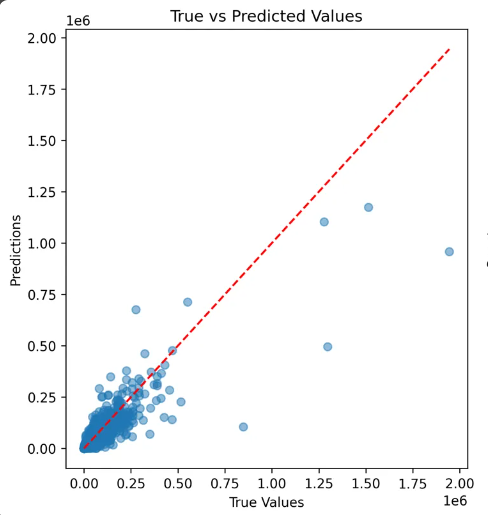

## 2. Multimodal Integration Evolution

Four distinct architectural approaches were investigated:

- Model 1: Basic Multimodal Integration
- Model 2: Attention-Enhanced Architecture
- Model 3: CLIP Integration
- Model 4: Attention (Model 2) + MLP backbone

### Model 1: Basic Multimodal Integration
- Leveraged the optimized XGBoost model from Step 1 as a feature extractor

- Key Components:
  - XGBoost feature extractor
  - DistilBERT for text encoding
  - EfficientNet-B0 with fine-tuned last 4 layers

- R² Score: 0.9547

In [10]:
import joblib
import wandb
from torchvision import transforms
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
import pytorch_lightning as pl
from transformers import DistilBertModel
from torch.utils.data import DataLoader
from trainning.utils import load_data
from transformers import DistilBertTokenizer


from trainning.models import (
    MultimodalBasicModel
)
from trainning.datasets import (
    MultimodalBERTDataset
)

def train_1():
    BATCH_SIZE = 64
    NUM_WORKERS = 4

    text_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

    train_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                             0.229, 0.224, 0.225])
    ])

    test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                             0.229, 0.224, 0.225])
    ])

    X_train_preprocessed, y_train, X_test_preprocessed, y_test, desc_train, desc_test, image_folder = load_data()

    train_dataset = MultimodalBERTDataset(
        X_train_preprocessed,
        desc_train,
        image_folder,
        y_train,
        tokenizer,
        transform=train_transform
    )

    test_dataset = MultimodalBERTDataset(
        X_test_preprocessed,
        desc_test,
        image_folder,
        y_test,
        tokenizer,
        transform=test_transform
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    loaded_xgb_model = joblib.load('optuna_best_model.joblib')

    model = MultimodalBasicModel(
        xgb_model=loaded_xgb_model,
        text_model=text_model,
        text_dim=768,
        learning_rate=0.001
    )

    wandb_logger = WandbLogger(
        project="candidate_challenge", name="multimodal-xgb-efficientnet_b0-distilbert")

    callbacks = [
        ModelCheckpoint(
            monitor='val_loss',
            dirpath='checkpoints',
            filename='multimodal-{epoch:02d}-{val_loss:.2f}',
            save_top_k=1,
            mode='min'
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            mode='min'
        ),
        LearningRateMonitor(logging_interval='step'),
    ]

    trainer = pl.Trainer(
        max_epochs=5,
        accelerator='auto',
        devices=1,
        logger=wandb_logger,
        callbacks=callbacks,
        log_every_n_steps=10,
        gradient_clip_val=1.0,
        precision=16
    )

    trainer.fit(model, train_loader, test_loader)
    trainer.validate(model, test_loader)
    wandb.finish()


train_1()

Removing columns with all missing values: ['feature_12', 'feature_17']
created


/home/michal/code/challenge/env_tranning/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/michal/code/challenge/env_tranning/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/michal/code/challenge/env_tranning/lib/python3.12/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda)

Epoch 4: 100%|██████████| 504/504 [14:11<00:00,  0.59it/s, v_num=nv7b, train_loss_step=0.105, val_loss_step=0.101, val_loss_epoch=0.0836, train_loss_epoch=0.108]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 504/504 [14:16<00:00,  0.59it/s, v_num=nv7b, train_loss_step=0.105, val_loss_step=0.101, val_loss_epoch=0.0836, train_loss_epoch=0.108]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 126/126 [02:27<00:00,  0.86it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           mse              0.08357830345630646
           r2               0.9547684788703918
     val_loss_epoch         0.08357831835746765
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆████
lr-AdamW,██████████████▇▇▇▇▇▇▅▅▅▅▅▃▃▃▃▃▃▃▃▃▁▁▁▁▁▁
mse,█▄▂▂▁▁▁
r2,▁▅▇▇███
train_loss_epoch,██▁▁▁▁
train_loss_step,█▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▂▁▁▁▁▃▁▂▂▁▃▃▄▂▂▂▂▂▄▅▂▂▂▂▇▂▂▂▂█▃▃▃▃▁▁▁▁▁
val_loss_epoch,█▄▂▂▁▁▁
val_loss_step,▇▇█▄▄▂▃▄▆▃▂▃▂▃▂▂▄▂▅▂▂▂▃▂▂▄▁▂▂▂▂▃▂▁▁▁▂▁▂▁
epoch,5
lr-AdamW,0.0001


### Model 2: Attention-Enhanced Architecture
Added attention layers to capture the interdependencies between the image and text features.
- R² Score: 0.9554
- **Observation:** Increased performace compared to the basic model. Increased tranning time.

In [12]:
import joblib
import wandb
from torchvision import transforms
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
import pytorch_lightning as pl
from transformers import DistilBertModel
from torch.utils.data import DataLoader
from trainning.utils import load_data
from transformers import DistilBertTokenizer


from trainning.models import (
    MultimodalAttentionModel
)
from trainning.datasets import (
    MultimodalBERTDataset
)


def train_2():
    BATCH_SIZE = 64
    NUM_WORKERS = 4

    text_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

    train_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                             0.229, 0.224, 0.225])
    ])

    test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                             0.229, 0.224, 0.225])
    ])

    X_train_preprocessed, y_train, X_test_preprocessed, y_test, desc_train, desc_test, image_folder = load_data()

    train_dataset = MultimodalBERTDataset(
        X_train_preprocessed,
        desc_train,
        image_folder,
        y_train,
        tokenizer,
        transform=train_transform
    )

    test_dataset = MultimodalBERTDataset(
        X_test_preprocessed,
        desc_test,
        image_folder,
        y_test,
        tokenizer,
        transform=test_transform
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    loaded_xgb_model = joblib.load('optuna_best_model.joblib')

    model = MultimodalAttentionModel(
        xgb_model=loaded_xgb_model,
        text_model=text_model,
        text_dim=768,
        learning_rate=0.001
    )

    wandb_logger = WandbLogger(
        project="candidate_challenge", name="multimodal-attention-xgb-efficientnet_b0-distilbert")

    callbacks = [
        ModelCheckpoint(
            monitor='val_loss',
            dirpath='checkpoints',
            filename='multimodal-attention{epoch:02d}-{val_loss:.2f}',
            save_top_k=1,
            mode='min'
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            mode='min'
        ),
        LearningRateMonitor(logging_interval='step'),
    ]

    trainer = pl.Trainer(
        max_epochs=5,
        accelerator='auto',
        devices=1,
        logger=wandb_logger,
        callbacks=callbacks,
        log_every_n_steps=10,
        gradient_clip_val=1.0,
        precision=16
    )

    trainer.fit(model, train_loader, test_loader)
    trainer.validate(model, test_loader)
    wandb.finish()


train_2()

Removing columns with all missing values: ['feature_12', 'feature_17']
created


/home/michal/code/challenge/env_tranning/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/michal/code/challenge/env_tranning/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/michal/code/challenge/env_tranning/lib/python3.12/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda)

Epoch 4: 100%|██████████| 504/504 [12:44<00:00,  0.66it/s, v_num=atf2, train_loss_step=0.113, val_loss_step=0.141, val_loss_epoch=0.0823, train_loss_epoch=0.0722] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 504/504 [12:44<00:00,  0.66it/s, v_num=atf2, train_loss_step=0.113, val_loss_step=0.141, val_loss_epoch=0.0823, train_loss_epoch=0.0722]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 126/126 [02:17<00:00,  0.91it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           mse              0.08228185772895813
           r2                0.955470085144043
     val_loss_epoch         0.08228185027837753
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▁▁▁▃▃▃▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆████
lr-AdamW,██████▇▇▇▇▅████▇▇▇▇▇▅▅▅▅▅▅▅▅▅▃▃▃▃▃▃▁▁▁▁▁
mse,▆▂█▃▃▁▁▁
r2,▃▇▁▆▆███
train_loss_epoch,█▁█▁▁▁▁
train_loss_step,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▂▂▁▁▂▃▁▁▂▄▁▁▂▁▁▁▁▃▄▂▄▄▅▂▂▂▂▆█▂▃▃▃▃▁▁▁▁
val_loss_epoch,▆▂█▃▃▁▁▁
val_loss_step,▃▅▂▃▆▄▅▃▂▂▂▂▄▃█▄▅▂▄▂▂▃▃▂▆▂▃▃▂▁▂▁▂▂▁▂▂▁▂▂
epoch,5
lr-AdamW,0.0001


### Model 3: CLIP Integration
- Model 2 showed increased performace -> to not train attention layers from scratch we can make use of pretrained CLIP model. The model could benefit from attention + faster trainning speed (using pretrained weights)
- R² Score: 0.9015
- **Observation:** CLIP showed weaker performace during tranning

In [4]:
import joblib
import wandb
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from trainning.utils import load_data, custom_collate


from trainning.models import (
    MultimodalClipModel
)
from trainning.datasets import (
    MultimodalCLIPDataset
)



def train_3():
    BATCH_SIZE = 64
    NUM_WORKERS = 4
    X_train_preprocessed, y_train, X_test_preprocessed, y_test, desc_train, desc_test, image_folder = load_data()

    train_dataset = MultimodalCLIPDataset(
        X_train_preprocessed,
        desc_train,
        image_folder,
        y_train,
    )

    test_dataset = MultimodalCLIPDataset(
        X_test_preprocessed,
        desc_test,
        image_folder,
        y_test,
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
        collate_fn=custom_collate
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
        collate_fn=custom_collate
    )

    loaded_xgb_model = joblib.load('optuna_best_model.joblib')

    model = MultimodalClipModel(
        xgb_model=loaded_xgb_model,
        clip_model_name="openai/clip-vit-base-patch32",
        learning_rate=0.0005
    )

    wandb_logger = WandbLogger(
        project="candidate_challenge", name="multimodal-clip-xgboost")

    callbacks = [
        ModelCheckpoint(
            monitor='val_loss',
            dirpath='checkpoints',
            filename='multimodal-clip-xgboost-{epoch:02d}-{val_loss:.2f}',
            save_top_k=1,
            mode='min'
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            mode='min'
        ),
        LearningRateMonitor(logging_interval='step'),
    ]

    trainer = pl.Trainer(
        max_epochs=7,
        accelerator='auto',
        devices=1,
        logger=wandb_logger,
        callbacks=callbacks,
        log_every_n_steps=10,
        gradient_clip_val=1.0,
        precision=16
    )

    trainer.fit(model, train_loader, test_loader)
    trainer.validate(model, test_loader)
    wandb.finish()


train_3()

Removing columns with all missing values: ['feature_12', 'feature_17']
created


/home/michal/code/challenge/env_tranning/lib/python3.12/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/michal/code/challenge/env_tranning/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/michal/code/imnoo/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type       | Params | Mode 
---------------------------------------------------
0 | criterion   | MSELoss    | 0      | train
1 | clip        | CLIPModel  | 151 M  | eval 
2 | combined_fc | Sequential | 279 K  | train
---------------------------------------------------
151 M     Trainable params
0         Non-trainable params
151 M     Total params
606.228   Total estimated model params size (MB)
9         Modules in train mode
306       Modules in eval mode


Epoch 6: 100%|██████████| 504/504 [17:56<00:00,  0.47it/s, v_num=zqb7, train_loss_step=0.154, val_loss_step=0.146, val_loss_epoch=0.182, train_loss_epoch=0.202]

`Trainer.fit` stopped: `max_epochs=7` reached.


Epoch 6: 100%|██████████| 504/504 [17:56<00:00,  0.47it/s, v_num=zqb7, train_loss_step=0.154, val_loss_step=0.146, val_loss_epoch=0.182, train_loss_epoch=0.202]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 126/126 [03:53<00:00,  0.54it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           mse              0.1818767637014389
           r2               0.9015706181526184
     val_loss_epoch         0.1818767637014389
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████
lr-AdamW,███▇▇▇▇▇▇▇▇▅▅▅▅▅▃▃▁▁▁▁▁▁▁▁██████████████
mse,▄▂█▃▁▄▅▅
r2,▅▇▁▆█▅▄▄
train_loss_epoch,█▁▁▁▁▁▁
train_loss_step,█▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▂▁▁▁▃▃▃▃▁▄▄▁▂▂▄▅▂▂▂▂▅▅▆▆▂▂▂▆▆▇▂▂▂██▃▃▃▁
val_loss_epoch,▄▂█▃▁▄▅▅
val_loss_step,▃▂▂▄▄▁▃▁█▇▅▃▁▅▃▃▂▃▂▃▂▂▂▂▃▃▁▃▃▃▃▂▁▂▃▃▅▃▂▃
epoch,7
lr-AdamW,0.00049


### Model 4: Attention + MLP backbone
Model 2 showed best perforamce yet. Let's try different approach by changing backbone architecture.
- XGBoost was replaced with MLP
- R² Score: **0.954**
- **Observation:** Convergence of MLP layers was much faster than using xgboost as backbone. Slightly weaker performace

In [1]:
import joblib
import wandb
from torchvision import transforms
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
import pytorch_lightning as pl
from transformers import DistilBertModel
from torch.utils.data import DataLoader
from trainning.utils import load_data
from transformers import DistilBertTokenizer


from trainning.models import (
    MultimodalMLPAttentionModel
)
from trainning.datasets import (
    MultimodalBERTDataset
)


def train_4():
    BATCH_SIZE = 64
    NUM_WORKERS = 4

    text_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

    train_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                             0.229, 0.224, 0.225])
    ])

    test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                             0.229, 0.224, 0.225])
    ])

    X_train_preprocessed, y_train, X_test_preprocessed, y_test, desc_train, desc_test, image_folder = load_data()

    train_dataset = MultimodalBERTDataset(
        X_train_preprocessed,
        desc_train,
        image_folder,
        y_train,
        tokenizer,
        transform=train_transform
    )

    test_dataset = MultimodalBERTDataset(
        X_test_preprocessed,
        desc_test,
        image_folder,
        y_test,
        tokenizer,
        transform=test_transform
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    model = MultimodalMLPAttentionModel(
        input_len=426,
        text_model=text_model,
        text_dim=768,
        learning_rate=0.001
    )

    wandb_logger = WandbLogger(
        project="candidate_challenge", name="multimodal-attention-mlp-efficientnet_b0-distilbert")

    callbacks = [
        ModelCheckpoint(
            monitor='val_loss',
            dirpath='checkpoints',
            filename='multimodal-attention-mlp{epoch:02d}-{val_loss:.2f}',
            save_top_k=1,
            mode='min'
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            mode='min'
        ),
        LearningRateMonitor(logging_interval='step'),
    ]

    trainer = pl.Trainer(
        max_epochs=5,
        accelerator='auto',
        devices=1,
        logger=wandb_logger,
        callbacks=callbacks,
        log_every_n_steps=10,
        gradient_clip_val=1.0,
        precision=16
    )

    trainer.fit(model, train_loader, test_loader)
    trainer.validate(model, test_loader)
    wandb.finish()


train_4()

/home/michal/code/challenge/env_tranning/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Removing columns with all missing values: ['feature_12', 'feature_17']
created


/home/michal/code/challenge/env_tranning/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/michal/code/challenge/env_tranning/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/michal/code/challenge/env_tranning/lib/python3.12/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda)

/home/michal/code/challenge/env_tranning/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/michal/code/imnoo/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type               | Params | Mode 
-----------------------------------------------------------
0 | criterion   | MSELoss            | 0      | train
1 | tabular_mlp | Sequential         | 63.4 K | train
2 | text_model  | DistilBertModel    | 66.4 M | eval 
3 | text_fc     | Linear             | 24.6 K | train
4 | img_model   | EfficientNet       | 5.3 M  | train
5 | image_fc    | Linear             | 32.0 K | train
6 | attention   | MultiheadAttention | 4.2 K  | train
7 | combined_fc | Sequential         | 671    | train
-----------------------------------------------------------
67.8 M    Trainable params
4.0 M     Non-trainable params
71.8 M    Total params
287.105   Total estimated model params size (MB)
356       Module

Epoch 4: 100%|██████████| 504/504 [14:02<00:00,  0.60it/s, v_num=c99w, train_loss_step=0.0829, val_loss_step=0.117, val_loss_epoch=0.085, train_loss_epoch=0.100] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 504/504 [14:07<00:00,  0.59it/s, v_num=c99w, train_loss_step=0.0829, val_loss_step=0.117, val_loss_epoch=0.085, train_loss_epoch=0.100]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 126/126 [02:20<00:00,  0.90it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           mse              0.08499753475189209
           r2               0.9540004134178162
     val_loss_epoch         0.08499753475189209
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆███████
lr-AdamW,█████████▇▅▅▅▅▅▅▅▅▅▅▅▅▅▃▃▃▃▃▃▃▃▃▁▁▁▁▁▁▁▁
mse,██▃▁▁▁
r2,▁▁▆███
train_loss_epoch,█▁▁▁▁
train_loss_step,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▁▁▁▁▃▃▃▄▁▂▄▂▂▂▂▆▇▂▂▂▂▂▇▇██▃▃▃▁▁▁▁▁▁
val_loss_epoch,██▃▁▁▁
val_loss_step,▅▇▅▄█▇▇▄▆█▄▆▆█▆▇▂▂▃▃▃▁▁▂▁▂▂▃▂▂▃▂▄▂▂▂█▁▂▁
epoch,5
lr-AdamW,0.0001


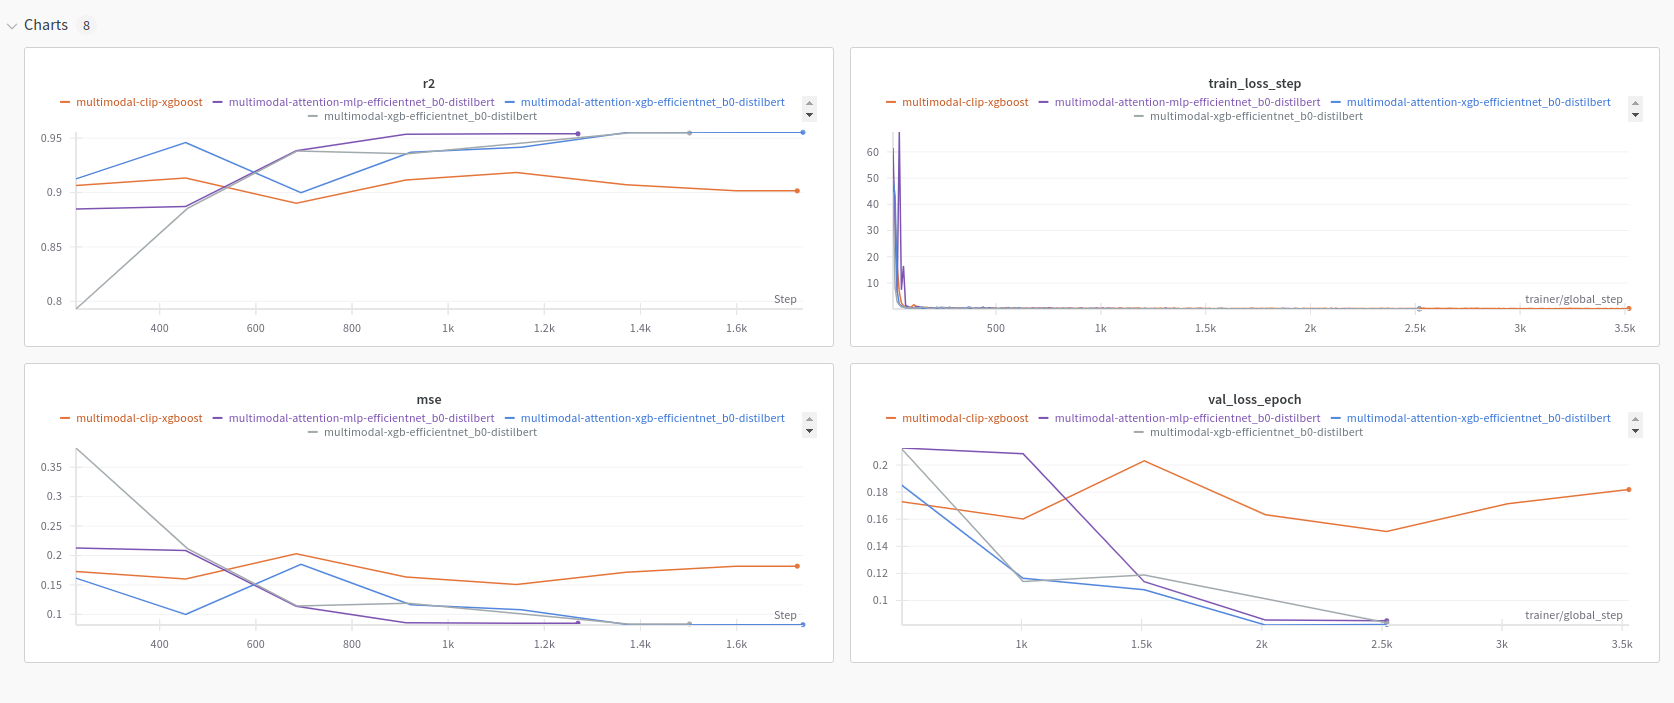

## 📈 3. Conclusions

This study explored various approaches for predicting a target variable using a combination of tabular, text, and image data.  In conclusion, incorporating multimodal information significantly improved predictive performance compared to using tabular data alone. 

**Multimodal Integration:**

* **Base Multimodal Integration (Model 1):**  The incorporation of text and image data, using DistilBERT and EfficientNet respectively, resulted in a substantial performance improvement over using tabular data alone. This highlights the significant contribution of multimodal information to the predictive task.
* **Attention-Enhanced Architecture (Model 2):** Adding attention mechanisms further improved performance, albeit marginally, compared to the base multimodal integration.  This indicates that explicitly modeling cross-modal interactions can enhance predictive accuracy.  However, this benefit came at the cost of increased training time.
* **Pretrained CLIP (Model 3):**  Utilizing a pretrained CLIP model for multimodal integration did not achieve a comparable level of accuracy to the BERT + CNN architectures. This suggests that, for this particular task, learning specialized embeddings for the text and image data through BERT and EfficientNet is more beneficial than using a generalized pretrained model like CLIP.
* **Attention + MLP Backbone (Model 4):** Replacing the XGBoost component for tabular data processing with an MLP within the attention-enhanced architecture (Model 2) resulted in significantly faster training convergence. This model nearly matched the performance of Model 2, demonstrating that an MLP can effectively process tabular data in a multimodal setting, offering a good balance between performance and training efficiency.
